In [1]:
# =========================================================
# 0) Setup (Colab installs) + Utilities
# =========================================================
!pip -q install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu121
!pip -q install numpy pandas scikit-learn einops tqdm
!pip -q install kagglehub tensorflow

import os, math, random, glob
from dataclasses import dataclass
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.metrics import average_precision_score, precision_recall_curve

def set_seed(seed=1337):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(1337)

device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_cuda = torch.cuda.is_available()
print("Device:", device)

Device: cuda


In [2]:
# =========================================================
# 1) Data: use existing NPZ tiles; if missing, build from Kaggle TFRecords (mNDWS)
# =========================================================
import os, glob, math, getpass
import numpy as np
from tqdm import tqdm

def pick_npz_root(subdir="wildfire_npz_tiles_mndws_v1"):
    user = os.environ.get("USER") or getpass.getuser() or "user"
    candidates = [
        os.environ.get("NPZ_ROOT"),                                   # explicit override (full path)
        os.path.join(os.environ["SCRATCH"], subdir) if "SCRATCH" in os.environ else None,
        f"/scratch/{user}/{subdir}",                                   # Rivanna default
        f"/content/{subdir}" if os.path.isdir("/content") else None,   # Colab
        os.path.join(os.path.expanduser("~"), subdir),                 # fallback
    ]
    for p in candidates:
        if not p: 
            continue
        try:
            os.makedirs(p, exist_ok=True)
            return p
        except OSError:
            continue
    raise RuntimeError("Could not create NPZ root in any candidate location")

NPZ_ROOT = pick_npz_root()
print("NPZ_ROOT ->", NPZ_ROOT)

def have_npz(root):
    return len(glob.glob(os.path.join(root, "*.npz"))) > 0

if not have_npz(NPZ_ROOT):
    print("No NPZ tiles found — converting from mNDWS TFRecords...")
    import kagglehub, tensorflow as tf

    # Modified Next Day Wildfire Spread dataset
    path = kagglehub.dataset_download("georgehulsey/modified-next-day-wildfire-spread")
    print("Kaggle dataset path:", path)

    # Look recursively in case TFRecords are split by split folders
    tfrecs = sorted(
        glob.glob(os.path.join(path, "**", "*.tfrecord"), recursive=True)
        + glob.glob(os.path.join(path, "**", "*.tfrecords"), recursive=True)
    )
    assert len(tfrecs) > 0, "No TFRecords found in mNDWS dataset."

    os.makedirs(NPZ_ROOT, exist_ok=True)

    # mNDWS expected feature keys (each 64x64 flattened to 4096)
    # Include viirs_* masks + legacy aliases for robustness.
    keys = [
        # labels/masks
        "viirs_PrevFireMask","viirs_FireMask",
        "PrevFireMask","FireMask",
        # vegetation/topography
        "NDVI","elevation",
        # population for barrier proxy
        "population",
        # mNDWS meteorology
        "avg_sph","tmp_day","tmp_75",
        "wind_avg","wdir_wind","gust_med","wdir_gust","wind_75",
        # hydrology/landcover
        "water","impervious",
        # drought and precip
        "pdsi","pr",
        # fire danger and embeddings
        "erc","bi","chili","fuel1","fuel2","fuel3",
        # optional id
        "sample_id"
    ]

    def read_flat_float32(feat):
        fl = feat.float_list.value
        if len(fl) == 0: return None
        arr = np.asarray(fl, dtype=np.float32)
        if arr.size == 4096:
            return arr.reshape(64, 64)
        s = int(round(math.sqrt(arr.size)))
        assert s*s == arr.size, f"Unexpected length {arr.size}"
        return arr.reshape(s, s)

    def wind_uv_by(speed, theta):
        if speed is None or theta is None:
            return None, None
        th = theta.copy()
        # mNDWS dirs commonly in radians ([-pi, pi]); convert if degrees.
        if np.nanmax(np.abs(th)) > 6.4:
            th = np.deg2rad(th % 360.0)
        u = speed * np.cos(th)
        v = speed * np.sin(th)
        return u.astype(np.float32), v.astype(np.float32)

    def slope_aspect_from_elevation(z):
        gy, gx = np.gradient(z.astype(np.float32))
        mag = np.sqrt(gx**2 + gy**2)
        q95 = np.percentile(mag, 95) + 1e-6
        slope  = np.clip(mag / q95, 0, 1).astype(np.float32)
        aspect = np.arctan2(-gy, -gx).astype(np.float32)  # [-pi, pi]
        return slope, aspect

    def ndvi_to_01(ndvi):
        nd = ndvi.astype(np.float32)
        # mNDWS NDVI is scaled (e.g., [-2000..9987]). Convert to [-1,1] via /10000
        if np.nanmax(np.abs(nd)) > 2.0:
            nd = nd / 10000.0
        # Map [-1,1] -> [0,1]
        nd = np.clip((nd + 1.0) / 2.0, 0, 1)
        return nd.astype(np.float32)

    def rh_from_avg_sph(avg_sph, tmp_day, tmp_75):
        # Proxy RH: normalize specific humidity by its 95th percentile
        # and damp by diurnal range signal (tmp_75 - tmp_day).
        if avg_sph is None:
            return np.zeros((64,64), np.float32)
        s95 = np.percentile(avg_sph, 95) + 1e-6
        rh = np.clip(avg_sph / s95, 0, 1)
        if tmp_day is not None and tmp_75 is not None:
            tr = np.clip((tmp_75 - tmp_day), 0, 20) / 20.0
            rh = rh * (1.0 - 0.5*tr)
        return np.clip(rh, 0, 1).astype(np.float32)

    def barrier_from_population(pop):
        if pop is None:
            return np.zeros((64,64), np.float32)
        pop = np.clip(pop, 0, None).astype(np.float32)
        thr = np.percentile(pop, 90)
        return (pop >= thr).astype(np.float32)

    def pick_first(*vals):
        for v in vals:
            if v is not None:
                return v
        return None

    converted = 0
    skipped_missing_masks = 0

    for f in tqdm(tfrecs, desc="Converting TFRecords → NPZ (mNDWS)"):
        for raw in tf.data.TFRecordDataset(f):
            ex = tf.train.Example.FromString(raw.numpy()).features.feature
            A = {k: read_flat_float32(ex[k]) if k in ex else None for k in keys}

            # Masks: prefer viirs_*; fall back to legacy names
            prev_mask = pick_first(A.get("viirs_PrevFireMask"), A.get("PrevFireMask"))
            next_mask = pick_first(A.get("viirs_FireMask"),     A.get("FireMask"))
            if prev_mask is None or next_mask is None:
                skipped_missing_masks += 1
                continue

            # Labels
            prev_fire = (prev_mask > 0.5).astype(np.float32)
            next_fire = (next_mask > 0.5).astype(np.float32)

            # Temperature: use mNDWS daily mean (tmp_day)
            if A["tmp_day"] is not None:
                temp = A["tmp_day"].astype(np.float32)
            else:
                temp = np.zeros((64,64), np.float32)

            # Wind: use wind_avg + wdir_wind (mNDWS)
            u, v = wind_uv_by(A["wind_avg"], A["wdir_wind"])
            if u is None or v is None:
                # Fallback to gust-based if average missing
                u, v = wind_uv_by(A["gust_med"], A["wdir_gust"])
                if u is None or v is None:
                    u = np.zeros((64,64), np.float32)
                    v = np.zeros((64,64), np.float32)

            # NDVI: rescale from scaled ints, then to [0,1]
            if A["NDVI"] is not None:
                ndvi = ndvi_to_01(A["NDVI"])
            else:
                ndvi = np.full((64,64), 0.5, np.float32)

            # Relative humidity proxy from avg_sph and temperatures
            rh = rh_from_avg_sph(A["avg_sph"], A["tmp_day"], A["tmp_75"])

            # Terrain
            if A["elevation"] is not None:
                slope, aspect = slope_aspect_from_elevation(A["elevation"])
            else:
                slope = np.zeros((64,64), np.float32)
                aspect = np.zeros((64,64), np.float32)

            # Barrier: population-based proxy
            barrier = barrier_from_population(A["population"])

            # Save minimal, consistent fields your pipeline expects.
            fields = dict(
                prev_fire=prev_fire, next_fire=next_fire,
                u=u, v=v, temp=temp, rh=rh, ndvi=ndvi,
                slope=slope, aspect=aspect, barrier=barrier
            )

            # Optional: keep extra mNDWS channels
            def _scale01(x, denom): return np.clip((x/denom), 0, 1).astype(np.float32)
            if A["impervious"] is not None: fields["impervious"] = _scale01(A["impervious"], 100.0)
            if A["water"] is not None:      fields["water"]      = _scale01(A["water"], 100.0)
            for k in ["erc","pdsi","pr","bi","chili","fuel1","fuel2","fuel3","wind_75","gust_med"]:
                if A.get(k) is not None: fields[k] = A[k].astype(np.float32)

            sid_feat = ex.get("sample_id", None)
            if sid_feat and len(sid_feat.bytes_list.value) > 0:
                sid = sid_feat.bytes_list.value[0].decode("utf-8")
            else:
                sid = f"{os.path.basename(f)}_{converted:07d}"

            np.savez(os.path.join(NPZ_ROOT, f"{sid}.npz"), **fields)
            converted += 1

    print(f"Converted {converted} tiles → {NPZ_ROOT}")
    print(f"Skipped (no masks): {skipped_missing_masks}")
else:
    print(f"Using existing NPZ tiles at {NPZ_ROOT} (found {len(glob.glob(os.path.join(NPZ_ROOT, '*.npz')))} files)")

NPZ_ROOT -> /scratch/jbm2rt/wildfire_npz_tiles_mndws_v1
No NPZ tiles found — converting from mNDWS TFRecords...


2025-11-12 11:57:50.162182: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Kaggle dataset path: /home/jbm2rt/.cache/kagglehub/datasets/georgehulsey/modified-next-day-wildfire-spread/versions/1


Converting TFRecords → NPZ (mNDWS):   0%|          | 0/54 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1762966677.006471  799677 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46727 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:61:00.0, compute capability: 8.6
I0000 00:00:1762966677.008572  799677 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46727 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:81:00.0, compute capability: 8.6
I0000 00:00:1762966677.010331  799677 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 46727 MB memory:  -> device: 2, name: NVIDIA RTX A6000, pci bus id: 0000:a1:00.0, compute capability: 8.6
I0000 00:00:1762966677.012409  799677 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 46727 MB memory:  -> device: 

Converted 20097 tiles → /scratch/jbm2rt/wildfire_npz_tiles_mndws_v1
Skipped (no masks): 0


In [3]:
# =========================================================
# 2) Dataset & configurable channel set (mNDWS)
# =========================================================
import os, glob
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from dataclasses import dataclass

# Base 9 channels used in NDWS workflows
CH_ORDER_BASE = [
    "prev_fire",    # 0
    "u",
    "v",
    "temp",
    "rh",
    "ndvi",
    "slope",
    "aspect",
    "barrier"       # 8
]

# Extra mNDWS channels saved by your converter (if present)
CH_ORDER_EXTRA = [
    "erc","pdsi","pr","bi","chili",
    "fuel1","fuel2","fuel3",
    "impervious","water",
    "wind_75","gust_med"
]

# Choose what to use
USE_CHANNELS = CH_ORDER_BASE + CH_ORDER_EXTRA  # or just CH_ORDER_BASE

# Channels that should pass through unchanged (no normalization)
DO_NOT_NORMALIZE = {"prev_fire", "barrier"}

@dataclass
class WildfirePaths:
    root: str  # NPZ_ROOT

_SPLIT_TO_ID = {"train": 0, "test": 1, "eval": 2, "val": 2}

def _infer_split_from_dir(root: str, split: str):
    sub = "eval" if split == "val" else split
    split_dir = os.path.join(root, sub)
    if os.path.isdir(split_dir):
        files = sorted(glob.glob(os.path.join(split_dir, "*.npz")))
        if files:
            return files
    return None

def _filter_by_split_id(files, split: str):
    wanted = _SPLIT_TO_ID[split]
    out = []
    for f in files:
        try:
            with np.load(f, mmap_mode="r") as z:
                if "split_id" in z and int(np.array(z["split_id"])) == wanted:
                    out.append(f)
        except Exception:
            pass
    return out

class WildfireDataset(Dataset):
    def __init__(self, paths: WildfirePaths, split="train", max_samples=None, seed=1337, channels=None):
        if split not in ("train","val","test","eval"):
            raise ValueError("split must be one of: train|val|test|eval")
        self.channels = list(USE_CHANNELS if channels is None else channels)

        # Prefer per-split subfolders, else split_id, else 70/15/15 fallback
        files = _infer_split_from_dir(paths.root, split)
        if files is None:
            all_files = sorted(glob.glob(os.path.join(paths.root, "*.npz")))
            if not all_files:
                raise ValueError(f"No .npz files under {paths.root}")
            has_split_id = False
            for probe in all_files[:10]:
                try:
                    with np.load(probe, mmap_mode="r") as z:
                        if "split_id" in z:
                            has_split_id = True
                            break
                except Exception:
                    continue
            if has_split_id:
                files = _filter_by_split_id(all_files, split)
            else:
                rng = np.random.default_rng(seed)
                shuffled = all_files.copy()
                rng.shuffle(shuffled)
                n = len(shuffled)
                n_train = int(round(0.70 * n))
                n_val = int(round(0.15 * n))
                if split == "train":
                    sel = np.arange(0, max(1, n_train))
                elif split in ("val","eval"):
                    sel = np.arange(n_train, max(n_train+1, n_train+n_val))
                else:
                    sel = np.arange(n_train+n_val, n) if (n_train+n_val) < n else np.arange(n-1, n)
                files = [shuffled[i] for i in sel]

        if max_samples:
            files = files[:max_samples]
        if len(files) == 0:
            any_file = sorted(glob.glob(os.path.join(paths.root, "**", "*.npz"), recursive=True))
            if not any_file:
                raise ValueError(f"No .npz files under {paths.root}")
            files = [any_file[0]]

        self.paths = paths
        self.files = files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        arr = np.load(self.files[i])
        # Always require minimal fields for labeling and core physics
        required = {"prev_fire","next_fire","u","v","temp","rh","ndvi","slope","aspect"}
        missing = [k for k in required if k not in arr]
        if missing:
            raise KeyError(f"{os.path.basename(self.files[i])} missing keys: {missing}")

        # Build X_raw in configured order; fill missing optional channels with zeros
        chans = []
        for k in self.channels:
            if k not in arr:
                # Gracefully handle optional extras missing in some NPZs
                chans.append(np.zeros_like(arr["prev_fire"], dtype=np.float32)[None, ...])
            else:
                chans.append(arr[k][None, ...].astype(np.float32))
        X_raw = np.concatenate(chans, axis=0)

        y = arr["next_fire"][None, ...].astype(np.float32)
        return {"X_raw": torch.from_numpy(X_raw), "y": torch.from_numpy(y)}

# Build datasets/loaders
paths = WildfirePaths(NPZ_ROOT)
train_ds = WildfireDataset(paths, split="train", max_samples=1200)
val_ds   = WildfireDataset(paths, split="eval",  max_samples=300)
test_ds  = WildfireDataset(paths, split="test",  max_samples=300)

def make_loader(ds, batch_size=16, upweight_positive=False, shuffle=False):
    if upweight_positive:
        weights = []
        for f in ds.files:
            try:
                y = np.load(f, mmap_mode="r")["next_fire"]
                weights.append(5.0 if y.sum() > 0 else 1.0)
            except Exception:
                weights.append(1.0)
        sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
        return DataLoader(ds, batch_size=batch_size, sampler=sampler,
                          num_workers=0, pin_memory=use_cuda, persistent_workers=False)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle,
                      num_workers=0, pin_memory=use_cuda, persistent_workers=False)

train_loader = make_loader(train_ds, batch_size=16, upweight_positive=True)
val_loader   = make_loader(val_ds,   batch_size=16)
test_loader  = make_loader(test_ds,  batch_size=16)

In [4]:
# =========================================================
# 3) Channel Stats for selected channels
# =========================================================
import numpy as np
import torch
from torch.utils.data import DataLoader

def build_channel_index(ds):
    # Map channel name -> index for DO_NOT_NORMALIZE handling
    name_to_idx = {name: idx for idx, name in enumerate(ds.channels)}
    return name_to_idx

@torch.no_grad()
def compute_channel_stats(ds, n_max_samples=None, batch_size=32):
    C = len(ds.channels)
    sums = np.zeros(C, dtype=np.float64)
    sqs  = np.zeros(C, dtype=np.float64)
    count = np.zeros(C, dtype=np.float64)

    loader = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=0)
    seen = 0
    for b in loader:
        x = b["X_raw"].numpy()          # (B,C,H,W)
        B, Cb, H, W = x.shape
        assert Cb == C
        x = x.reshape(B, C, -1)
        mask = ~np.isnan(x)
        sums += np.where(mask, x, 0.0).sum(axis=(0, 2))
        sqs  += np.where(mask, x*x, 0.0).sum(axis=(0, 2))
        count += mask.sum(axis=(0, 2))
        seen += B
        if n_max_samples and seen >= n_max_samples:
            break

    count = np.maximum(count, 1.0)
    mean = sums / count
    var  = np.maximum(sqs / count - mean**2, 1e-8)
    std  = np.sqrt(var)

    # Do not normalize certain channels
    idx = build_channel_index(ds)
    for name in DO_NOT_NORMALIZE:
        if name in idx:
            mean[idx[name]] = 0.0
            std[idx[name]]  = 1.0

    return torch.tensor(mean, dtype=torch.float32), torch.tensor(std, dtype=torch.float32)

meanC, stdC = compute_channel_stats(train_ds, n_max_samples=2000, batch_size=32)
meanC, stdC = meanC.to(device), stdC.to(device)
meanC.shape, stdC.shape, train_ds.channels

(torch.Size([21]),
 torch.Size([21]),
 ['prev_fire',
  'u',
  'v',
  'temp',
  'rh',
  'ndvi',
  'slope',
  'aspect',
  'barrier',
  'erc',
  'pdsi',
  'pr',
  'bi',
  'chili',
  'fuel1',
  'fuel2',
  'fuel3',
  'impervious',
  'water',
  'wind_75',
  'gust_med'])

In [5]:
# =========================================================
# 4) Pixel Logistic Regression (1x1 conv) — mNDWS channel-aware
# =========================================================
import torch.nn as nn

class PixelLogReg(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.lin = nn.Conv2d(in_ch, 1, kernel_size=1, bias=True)
    def forward(self, x):
        return self.lin(x)  # logits (B,1,H,W)

def build_lr_input(X_raw0, mean=meanC, std=stdC):
    # Normalize using stats for the configured channels
    return (X_raw0 - mean.view(1, -1, 1, 1)) / std.view(1, -1, 1, 1)

@torch.no_grad()
def pos_weight_from_loader(loader, max_batches=100):
    total_pos = 0
    total = 0
    for i, b in enumerate(loader):
        y = b["y"]
        total_pos += y.sum().item()
        total     += y.numel()
        if i+1 >= max_batches: break
    pos = max(total_pos, 1.0)
    neg = max(total - total_pos, 1.0)
    return torch.tensor(neg / pos, dtype=torch.float32, device=device)

# Match model input to selected channels
n_ch = len(train_ds.channels)
assert meanC.numel() == n_ch and stdC.numel() == n_ch, "Stats must match channel count"

lr_model = PixelLogReg(in_ch=n_ch).to(device)
pw = pos_weight_from_loader(train_loader)
criterion = nn.BCEWithLogitsLoss(pos_weight=pw)
optimizer = torch.optim.AdamW(lr_model.parameters(), lr=1e-3, weight_decay=1e-4)
EPOCHS_LR = 5
print("in_ch =", n_ch, "pos_weight =", float(pw))

in_ch = 21 pos_weight = 32.9764289855957


In [6]:
# =========================================================
# 5) Train / Eval loops
# =========================================================
def train_lr_epoch():
    lr_model.train()
    losses=[]
    for b in tqdm(train_loader, desc="train LR", leave=False):
        X_raw0, y = b["X_raw"].to(device), b["y"].to(device)
        X = build_lr_input(X_raw0)
        logits = lr_model(X)
        loss = criterion(logits, y)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        losses.append(loss.item())
    return float(np.mean(losses))

@torch.no_grad()
def eval_lr(loader):
    lr_model.eval()
    all_p, all_t = [], []
    for b in tqdm(loader, desc="eval LR", leave=False):
        X_raw0, y = b["X_raw"].to(device), b["y"].to(device)
        X = build_lr_input(X_raw0)
        p = torch.sigmoid(lr_model(X)).flatten().cpu().numpy()
        t = y.flatten().cpu().numpy()
        all_p.append(p); all_t.append(t)
    p = np.concatenate(all_p); t = np.concatenate(all_t)
    if t.sum()==0:
        return 0.0, 0.0, 0.5
    ap = average_precision_score(t, p)
    prec, rec, thr = precision_recall_curve(t, p)
    f1 = (2*prec*rec)/(prec+rec+1e-8)
    best_idx = f1.argmax()
    best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
    return float(ap), float(f1.max()), float(best_thr)

best_val_ap_lr = -1.0
best_state = None

for e in range(EPOCHS_LR):
    tr = train_lr_epoch()
    ap, f1, thr = eval_lr(val_loader)
    print(f"[LR] Epoch {e:02d} | loss {tr:.4f} | VAL AP {ap:.4f} | VAL F1* {f1:.4f} | thr≈{thr:.3f}")
    if ap > best_val_ap_lr:
        best_val_ap_lr = ap
        best_state = {k: v.cpu().clone() for k, v in lr_model.state_dict().items()}

# Restore best model and recompute best threshold on VAL
if best_state is not None:
    lr_model.load_state_dict(best_state)

_, _, best_thr_val = eval_lr(val_loader)

@torch.no_grad()
def test_at_thr(thr):
    lr_model.eval()
    all_p, all_t = [], []
    for b in tqdm(test_loader, desc="test LR", leave=False):
        X_raw0, y = b["X_raw"].to(device), b["y"].to(device)
        X = build_lr_input(X_raw0)
        p = torch.sigmoid(lr_model(X)).flatten().cpu().numpy()
        t = y.flatten().cpu().numpy()
        all_p.append(p); all_t.append(t)
    p = np.concatenate(all_p); t = np.concatenate(all_t)
    ap = average_precision_score(t, p)
    yhat = (p >= thr).astype(np.float32)
    tp = (yhat*t).sum(); fp = (yhat*(1-t)).sum(); fn = ((1-yhat)*t).sum()
    prec = tp/(tp+fp+1e-8); rec = tp/(tp+fn+1e-8)
    f1 = 2*prec*rec/(prec+rec+1e-8)
    print(f"[LR] TEST @thr={thr:.3f} | AP={ap:.4f} | P={prec:.3f} R={rec:.3f} F1={f1:.3f}")
    return ap, f1

test_ap_lr, test_f1_lr = test_at_thr(best_thr_val)

[LR] Epoch 00 | loss 1.3072 | VAL AP 0.0503 | VAL F1* 0.1043 | thr≈0.641


[LR] Epoch 01 | loss 1.2718 | VAL AP 0.0633 | VAL F1* 0.1269 | thr≈0.660


[LR] Epoch 02 | loss 1.2282 | VAL AP 0.0738 | VAL F1* 0.1468 | thr≈0.680


[LR] Epoch 03 | loss 1.1914 | VAL AP 0.0847 | VAL F1* 0.1680 | thr≈0.691


[LR] Epoch 04 | loss 1.1430 | VAL AP 0.0930 | VAL F1* 0.1816 | thr≈0.686


[LR] TEST @thr=0.686 | AP=0.1005 | P=0.149 R=0.239 F1=0.184



[LR] Coefficients (sorted by |weight|):
  prev_fire        +0.3850
  bi               +0.2789
  pdsi             -0.2386
  erc              +0.1936
  gust_med         +0.1558
  barrier          -0.1409
  wind_75          -0.1104
  rh               -0.0992
  fuel2            +0.0910
  v                -0.0864
  impervious       -0.0620
  slope            +0.0492
  ... (+9 more)
[LR] Bias: -0.0638


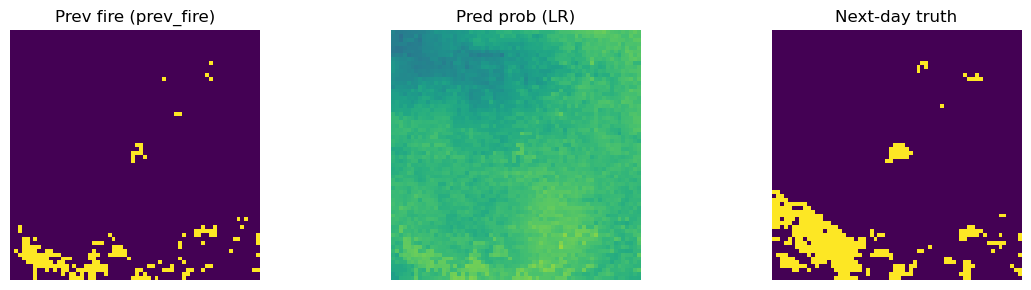

In [7]:
# =========================================================
# 6) Inspect coefficients + quick viz (channel-aware)
# =========================================================
import numpy as np
import torch
import matplotlib.pyplot as plt

with torch.no_grad():
    # Weight per input channel
    W = lr_model.lin.weight[0, :, 0, 0].detach().cpu().numpy()   # shape (C,)
    B = float(lr_model.lin.bias.item())

# Use the dataset's channel names (matches model input order)
channel_names = list(train_ds.channels)  # e.g., ["prev_fire","u","v",...]
assert len(W) == len(channel_names), "Weight length must match channel count"

# Sort by absolute weight; show top-k (or all)
top_k = min(12, len(W))
coef_sorted = sorted(zip(channel_names, W), key=lambda x: -abs(x[1]))
print("\n[LR] Coefficients (sorted by |weight|):")
for name, w in coef_sorted[:top_k]:
    print(f"  {name:16s} {w:+.4f}")
if top_k < len(W):
    print(f"  ... (+{len(W)-top_k} more)")
print(f"[LR] Bias: {B:+.4f}")

# Quick qualitative visualization (prev_fire, pred prob, next truth)
@torch.no_grad()
def show_one_lr(ds, i=0):
    names = ds.channels
    prev_idx = names.index("prev_fire") if "prev_fire" in names else 0

    b = ds[i]
    X_raw0 = b["X_raw"].unsqueeze(0).to(device)       # (1,C,H,W)
    y = b["y"][0].numpy()                              # (H,W)

    X = build_lr_input(X_raw0, mean=meanC, std=stdC)   # uses channel-aware stats
    prob = torch.sigmoid(lr_model(X))[0, 0].cpu().numpy()

    prev_img = b["X_raw"][prev_idx].numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 3))
    axs[0].imshow(prev_img, vmin=0, vmax=1); axs[0].set_title(f"Prev fire ({names[prev_idx]})")
    axs[1].imshow(prob, vmin=0, vmax=1);     axs[1].set_title("Pred prob (LR)")
    axs[2].imshow(y, vmin=0, vmax=1);        axs[2].set_title("Next-day truth")
    for a in axs: a.axis('off')
    plt.tight_layout(); plt.show()

# Example
show_one_lr(test_ds, i=0)

In [8]:
# =========================================================
# 7) Save artifacts (channel-aware, non-/content path)
# =========================================================
import os
import torch

# Choose a writable artifacts directory (override with $ARTIFACTS_DIR if desired)
ART_DIR = os.path.join(os.environ.get("ARTIFACTS_DIR", os.path.expanduser("~/wildfire_artifacts")), "lr")
os.makedirs(ART_DIR, exist_ok=True)

artifact = {
    "state_dict": lr_model.state_dict(),
    "model": {"type": "PixelLogReg", "in_ch": len(train_ds.channels)},
    "channels": list(train_ds.channels),         # preserve input order
    "mean": meanC.cpu(),                         # channel-aware stats
    "std": stdC.cpu(),
    "pos_weight": float(pw),
    "best_thr": float(best_thr_val),
}

out_path = os.path.join(ART_DIR, "pixel_logreg.pt")
torch.save(artifact, out_path)
print(f"Saved model → {out_path}")

Saved model → /home/jbm2rt/wildfire_artifacts/lr/pixel_logreg.pt


In [9]:
test_ap_lr, test_f1_lr

(0.10053783141871346, np.float32(0.18378635))

In [10]:
from sklearn.metrics import average_precision_score, precision_recall_curve

# Reconfirm best threshold on VAL (uses your eval_lr)
val_ap, val_f1, best_thr_val = eval_lr(val_loader)
print(f"[LR] VAL: AP={val_ap:.4f} F1*={val_f1:.4f} thr≈{best_thr_val:.3f}")

@torch.no_grad()
def confusion_at_thr(loader, thr):
    lr_model.eval()
    tp = fp = tn = fn = 0
    for b in loader:
        X_raw0, y = b["X_raw"].to(device), b["y"].to(device)   # (B,1,H,W)
        X = build_lr_input(X_raw0)                              # normalize
        p = torch.sigmoid(lr_model(X)).flatten().cpu().numpy()  # probs
        t = y.flatten().cpu().numpy().astype(np.uint8)          # 0/1
        p = np.nan_to_num(p, nan=0.0)                           # safety
        yhat = (p >= thr).astype(np.uint8)

        tp += np.logical_and(yhat == 1, t == 1).sum()
        fp += np.logical_and(yhat == 1, t == 0).sum()
        tn += np.logical_and(yhat == 0, t == 0).sum()
        fn += np.logical_and(yhat == 0, t == 1).sum()

    tp, fp, tn, fn = map(int, (tp, fp, tn, fn))
    prec = tp / (tp + fp + 1e-8)
    rec  = tp / (tp + fn + 1e-8)
    f1   = 2 * prec * rec / (prec + rec + 1e-8)
    return dict(tp=tp, fp=fp, tn=tn, fn=fn,
                precision=float(prec), recall=float(rec), f1=float(f1))

print("VAL @thr:", confusion_at_thr(val_loader, best_thr_val))
print("TEST @thr:", confusion_at_thr(test_loader, best_thr_val))

[LR] VAL: AP=0.0930 F1*=0.1816 thr≈0.686
VAL @thr: {'tp': 10379, 'fp': 66628, 'tn': 1124867, 'fn': 26926, 'precision': 0.1347799550690022, 'recall': 0.27822007773749413, 'f1': 0.18159072973424845}
TEST @thr: {'tp': 9287, 'fp': 52946, 'tn': 1137024, 'fn': 29543, 'precision': 0.14922950846011776, 'recall': 0.23917074426983284, 'f1': 0.1837863463560187}


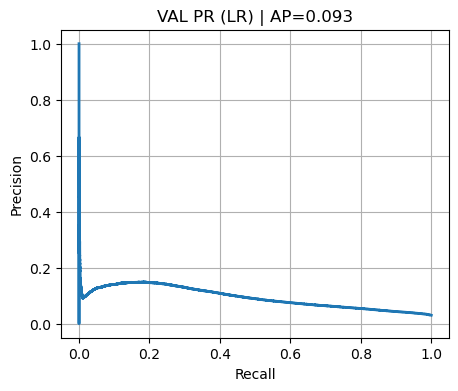

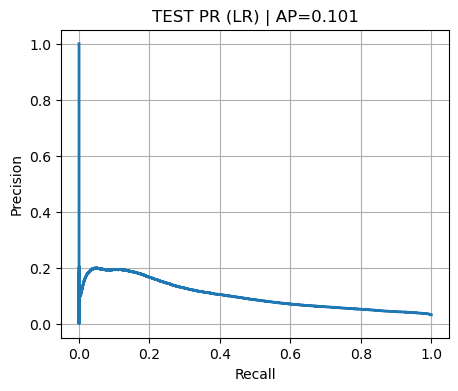

In [11]:
import matplotlib.pyplot as plt
@torch.no_grad()
def pr_curve(loader, title="PR Curve (LR)"):
    lr_model.eval()
    ps, ts = [], []
    for b in loader:
        X_raw0, y = b["X_raw"].to(device), b["y"].to(device)
        X = build_lr_input(X_raw0)
        p = torch.sigmoid(lr_model(X)).flatten().cpu().numpy()
        t = y.flatten().cpu().numpy()
        ps.append(p); ts.append(t)
    p = np.concatenate(ps); t = np.concatenate(ts)
    prec, rec, _ = precision_recall_curve(t, p)
    ap = average_precision_score(t, p)
    plt.figure(figsize=(5,4))
    plt.plot(rec, prec, lw=2)
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"{title} | AP={ap:.3f}")
    plt.grid(True); plt.show()

pr_curve(val_loader, "VAL PR (LR)")
pr_curve(test_loader, "TEST PR (LR)")


In [12]:
# Single-feature ablation: evaluate LR using one channel at a time
single_feats = list(train_ds.channels)  # uses the configured channel order

@torch.no_grad()
def eval_single_feature(idx, loader=val_loader):
    C = len(single_feats)
    assert 0 <= idx < C, f"idx out of range (got {idx}, C={C})"

    # Save current weights/bias
    W_orig = lr_model.lin.weight.detach().clone()  # (1,C,1,1)
    b_orig = lr_model.lin.bias.detach().clone()

    # Zero all weights except the selected channel
    W_only = torch.zeros_like(W_orig)
    W_only[0, idx, 0, 0] = W_orig[0, idx, 0, 0]

    lr_model.lin.weight.data.copy_(W_only)
    lr_model.lin.bias.data.copy_(b_orig)  # keep bias unchanged

    # Evaluate on the given loader
    ap, f1, _ = eval_lr(loader)

    # Restore original weights/bias
    lr_model.lin.weight.data.copy_(W_orig)
    lr_model.lin.bias.data.copy_(b_orig)

    return ap, f1

abl = []
for i, nm in enumerate(single_feats):
    ap_i, f1_i = eval_single_feature(i, loader=val_loader)
    abl.append((nm, ap_i, f1_i))

abl = sorted(abl, key=lambda x: -x[2])  # sort by F1
print("\n[LR] Single-feature VAL ablations (sorted by F1):")
for nm, ap_i, f1_i in abl:
    print(f"  {nm:16s}  AP={ap_i:.3f}  F1*={f1_i:.3f}")


[LR] Single-feature VAL ablations (sorted by F1):
  prev_fire         AP=0.210  F1*=0.439
  erc               AP=0.046  F1*=0.094
  pdsi              AP=0.043  F1*=0.089
  bi                AP=0.043  F1*=0.088
  rh                AP=0.040  F1*=0.073
  v                 AP=0.033  F1*=0.065
  slope             AP=0.035  F1*=0.065
  gust_med          AP=0.034  F1*=0.065
  barrier           AP=0.032  F1*=0.062
  fuel3             AP=0.030  F1*=0.062
  fuel2             AP=0.032  F1*=0.061
  fuel1             AP=0.029  F1*=0.061
  ndvi              AP=0.028  F1*=0.061
  water             AP=0.031  F1*=0.060
  u                 AP=0.030  F1*=0.060
  impervious        AP=0.030  F1*=0.060
  wind_75           AP=0.027  F1*=0.060
  aspect            AP=0.030  F1*=0.060
  pr                AP=0.030  F1*=0.059
  temp              AP=0.024  F1*=0.059
  chili             AP=0.029  F1*=0.059
